# Model Training

Contents
- Process data into one-hot encoded sequence vectors and targets.
- Break into train, validation, and test sets.
- Perform a modest hyper-parameter search.
- Conclude that a variety of hyperparameters result in similar performance.
- Train and save a model to use in rest of analysis.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

In [2]:
from genome import Genome
genome = Genome('../anno/hg19.fa')

In [3]:
introns = {}
with open('../preprocessing/introns_to_mercer.tsv') as fp:
    for line in fp:
        chrom, start, end, _, pos, strand, _, bp = line.split('\t')[:8]
        bp, start, end = int(bp), int(start), int(end)
        
        three = end if strand == '+' else start  
        key = (chrom, three, strand)
        
        if not 5 < abs(bp - three) < 60:
            bp = -1
        
        if key not in introns: introns[key] = []
        assert bp not in introns[key], bp
        if bp != -1: introns[key] += [bp]

In [4]:
# Used to compare to branchpointer
c = 0
with open('../anno/test.tsv', 'w') as fp:
    ID = 0
    fp.write('\t'.join(['id', 'chromsome', 'start', 'end', 'strand']) + '\n')
    for (chrom, three, strand), bp in introns.items():
        if not bp or chrom != 'chr1':
            continue
        if strand == '+':
            begin, end = str(three - 70), str(three)
        else:
            c += 1
            begin, end = str(three+1), str(three + 70+1)
        
        fp.write('\t'.join(["chr1_{}_{}".format(three, strand),
                            'chr1', begin, end, strand]) + '\n')
print c

2145


In [5]:
known   = {key: value for key, value in introns.items() if value}
missing = {key: value for key, value in introns.items() if not value}
print len(known)
print len(missing)

37110
169182


In [6]:
L = 70
bases = ['A', 'C', 'G', 'T']

def onehot(seq):
    X = np.zeros((len(seq), len(bases)))
    for i, char in enumerate(seq):
        X[i, bases.index(char)] = 1
    return X

X, y, chroms = [], [], []
for intron, bps in known.items():
    chrom, three, strand = intron
    if strand == '+':
        begin, stop = three - L, three
    else:
        begin, stop = three, three + L
    
    # Get features
    seq = genome.get_seq(chrom, begin, stop, strand)
    if 'N' in seq: seq = seq.replace('N', 'A')
    
    X += [onehot(seq).reshape(1, 70, 4)]

    # Make target
    _y = np.zeros((stop - begin,))
    for bp in bps:
        if strand == '+':
            bp = L + bp - three
        else:
            bp = L - bp + three - 1
        _y[bp] = 1
    y += [_y]
    
    chroms += [chrom]

X, y = np.vstack(X), np.vstack(y)
print X.shape, y.shape, len(chroms)

(37110, 70, 4) (37110, 70) 37110


In [7]:
test = np.array(map(lambda x: x == 'chr1', chroms))
valid = np.array(map(lambda x: x in ('chr2', 'chr3', 'chr4', 'chr5'),
                     chroms))
train = np.array([not (t or v) for t, v in zip(test, valid)])
print sum(test),  sum(valid), sum(train)

X_train, X_valid, X_test = X[train], X[valid], X[test]
y_train, y_valid, y_test = y[train], y[valid], y[test]
print X_train.shape, X_valid.shape, X_test.shape
print y_train.shape, y_valid.shape, y_test.shape

4306 7093 25711
(25711, 70, 4) (7093, 70, 4) (4306, 70, 4)
(25711, 70) (7093, 70) (4306, 70)


In [8]:
def matching(preds, true):
    total, match = 0, 0
    for p, t in zip(preds, true):
        if np.argmax(p) in np.nonzero(t)[0]:
            match += 1
        total += 1
    return match, total

# Compute PWM as sanity check

In [9]:
K = 3
counts = np.zeros((2*K+1, 4))
for target, seq in zip(y_train, X_train):
    for bp in np.nonzero(target)[0]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1]
print counts.T

[[  5543.   4025.   6580.  30750.   7524.   8726.   7128.]
 [ 15038.   6727.  13676.   3718.  13751.  12028.  11222.]
 [  6480.   5016.   8802.   1699.   6906.   6065.   7984.]
 [ 11990.  23283.   9993.   2884.  10870.  12232.  12717.]]


# Model trainer

In [11]:
class ModelTrainer:
    def __init__(self, model):
        self.model = model
        self.train_auc = []
        self.train_match = []
        self.valid_auc = []
        self.valid_match = []
        
    def train(self, X_train, X_valid,
              y_train, y_valid, PATIENCE = 15, EPOCHS = 1000):
        print model.summary()
        for i in range(EPOCHS):
            model.fit(X_train, y_train, epochs = 1, verbose = 0, batch_size = 8)
            self._evaluate(X_train, X_valid, y_train, y_valid)
            if (i > PATIENCE
                and max(self.valid_auc[-PATIENCE:])
                < max(self.valid_auc)):
                break
            print i, self.valid_match[-1], self.train_match[-1]
        self._plot_scores()
        print max(self.valid_match), max(self.valid_auc)
    
    def predict(X):
        return self.model.predict(X)
                
    def _evaluate(self, X_train, X_valid, y_train, y_valid):
        valid_preds = self.model.predict_proba(X_valid, verbose=0)
        train_preds = self.model.predict_proba(X_train, verbose=0)
        self.valid_match += [matching(valid_preds, y_valid)[0]
                             / float(y_valid.shape[0])]
        self.train_match += [matching(train_preds, y_train)[0]
                             / float(y_train.shape[0])]
        self.valid_auc += [metrics.roc_auc_score(y_valid.flatten(),
                                                 valid_preds.flatten())]
        self.train_auc += [metrics.roc_auc_score(y_train.flatten(),
                                                 train_preds.flatten())]
    
    def _plot_scores(self):
        plt.plot(self.valid_match, label = 'Validation')
        plt.plot(self.train_match, label = 'Training')
        plt.ylabel('Match')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()
        
        plt.plot(self.valid_auc, label = 'Validation')
        plt.plot(self.train_auc, label = 'Training')
        plt.ylabel('auROC')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Reshape, LSTM, Dropout
from keras.layers.convolutional import Conv2D
from keras import regularizers
from keras import optimizers
from keras.layers.wrappers import Bidirectional, TimeDistributed

Using Theano backend.


# Hyper param search

0.01 32 0.001 0.15 0.05 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_7 (Bidirection (None, 70, 64)            9472      
_________________________________________________________________
bidirectional_8 (Bidirection (None, 70, 64)            24832     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 70, 1)             65        
Total params: 34,369
Trainable params: 34,369
Non-trainable params: 0
_________________________________________________________________
None
0 0.567460876921 0.616778810626
1 0.567178908783 0.616273190463
2 0.633300437051 0.67352495041
3 0.645566051036 0.684337443118
4 0.649936557169 0.693983120065
5 0.651205413788 0.691143868383
6 0.656562808403 0.700167243592
7 0.647539827999 0.690754929797
8 0.651487381926 0.69530551126
9 0.668546454251 0.705690171522
10 0.673198928521 0.710901948582
11 0.668264486113 0.

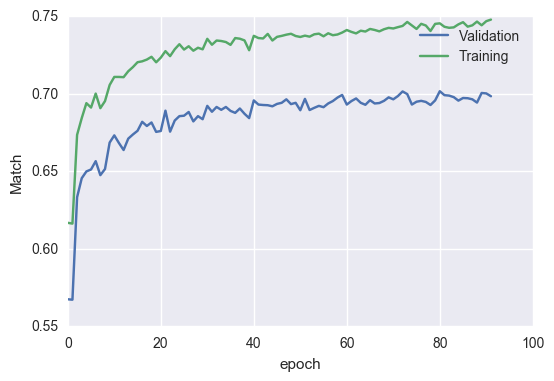

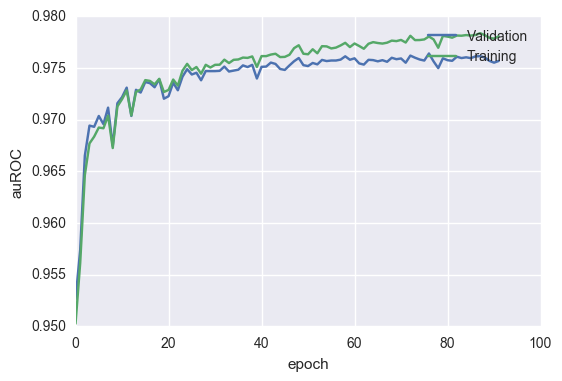

0.701677710419 0.976405679892
1e-05 32 0.001 0.15 0.05 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_9 (Bidirection (None, 70, 64)            9472      
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 70, 1)             65        
Total params: 34,369
Trainable params: 34,369
Non-trainable params: 0
_________________________________________________________________
None
0 0.552375581559 0.608144374003
1 0.621175807134 0.665318346233
2 0.645707035105 0.685543152736
3 0.654589031439 0.694177589359
4 0.651064429719 0.689549220178
5 0.669533342732 0.709385088095
6 0.667841533907 0.706351367119
7 0.661356266742 0.702461981253
8 0.677005498379 0.719419703629
9 0.680953052305 0.7219866983
10 0.688425207952 0.72

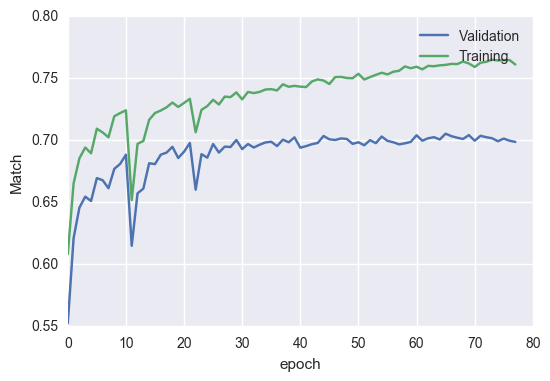

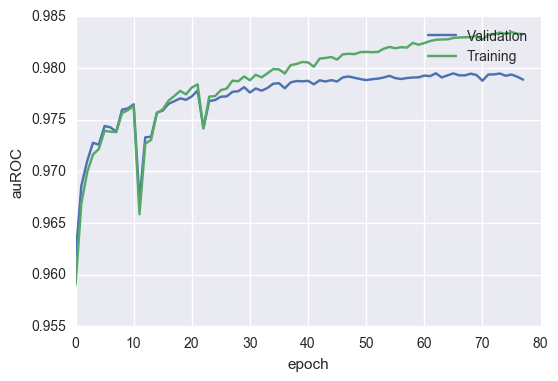

0.705343296208 0.979486028286
0.0001 32 0.001 0.15 0.05 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_11 (Bidirectio (None, 70, 64)            9472      
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 70, 1)             65        
Total params: 34,369
Trainable params: 34,369
Non-trainable params: 0
_________________________________________________________________
None
0 0.528267305794 0.585741511415
1 0.63104469195 0.673097117965
2 0.644015226279 0.682276068609
3 0.658677569435 0.697405779627
4 0.658536585366 0.694216483217
5 0.67333991259 0.706779199564
6 0.673198928521 0.712029870483
7 0.671789087833 0.709696238964
8 0.680107147892 0.718136206293
9 0.678556323135 0.717319435261
10 0.6850415903 0.724

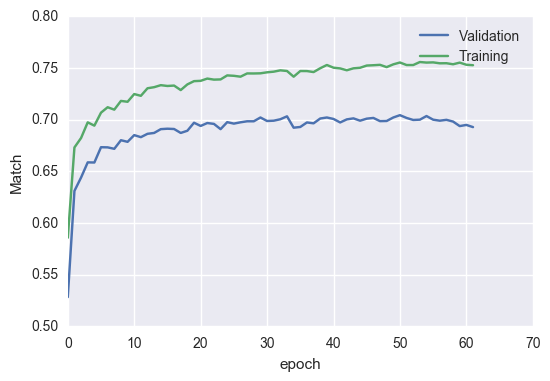

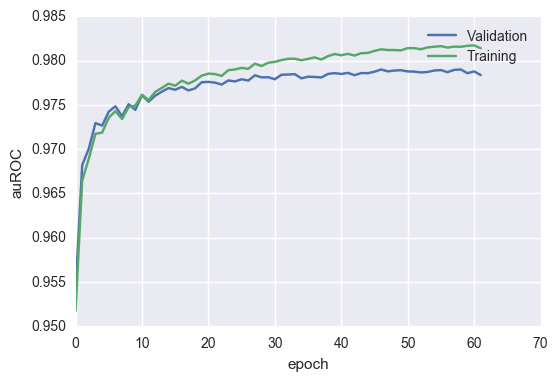

0.704356407726 0.979003441023


In [16]:
num_layers = [2]
l2s = [0.01, 0.00001, 0.0001]
hiddens = [32]
lrs = [0.001]
dropouts = [0.15]
r_dropouts = [0.05]

for l2 in l2s:
    for lr in lrs:
        for dropout in dropouts:
            for r_dropout in r_dropouts:
                for num_layer in num_layers:
                    for hidden in hiddens:
                        print l2, hidden, lr, dropout, r_dropout, num_layer
                        model = Sequential()
                        reg = regularizers.l2(0)

                        model.add(Bidirectional(LSTM(hidden, return_sequences = True,
                                                       dropout = dropout, recurrent_dropout = r_dropout,
                                                       kernel_regularizer = reg,
                                                       recurrent_regularizer = reg,
                                                       activity_regularizer = reg,
                                                       bias_regularizer = reg),
                                                 input_shape=(L, 4)))
                        for _ in range(num_layer-1):
                            model.add(Bidirectional(LSTM(hidden, return_sequences = True,
                                                           dropout = dropout, recurrent_dropout = r_dropout,
                                                           kernel_regularizer = reg,
                                                           recurrent_regularizer = reg,
                                                           activity_regularizer = reg,
                                                           bias_regularizer = reg)))

                        model.add(TimeDistributed(Dense(1, kernel_regularizer = regularizers.l2(l2), activation = 'sigmoid')))
                        model.compile(loss='binary_crossentropy',
                                      optimizer=optimizers.Adam(lr=lr,
                                                                beta_1=0.9,
                                                                beta_2=0.999,
                                                                epsilon=1e-08,
                                                                decay=0.0))
                        ModelTrainer(model).train(X_train, X_valid,
                                                  y_train.reshape(-1, 70, 1), y_valid.reshape(-1, 70, 1))

0 28 0.001 0.15 0.05 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_13 (Bidirectio (None, 70, 56)            7392      
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 70, 56)            19040     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 70, 1)             57        
Total params: 26,489
Trainable params: 26,489
Non-trainable params: 0
_________________________________________________________________
None
0 0.584096997039 0.634319940881
1 0.616241364726 0.659678736727
2 0.646411955449 0.687215588659
3 0.65332017482 0.689704795613
4 0.658113633159 0.698961533974
5 0.661074298604 0.697211310334
6 0.638939799803 0.674263933725
7 0.669533342732 0.707012562716
8 0.676300578035 0.712924429233
9 0.672775976315 0.713702306406
10 0.675172705484 0.716269301077
11 0.681657972649 0.72

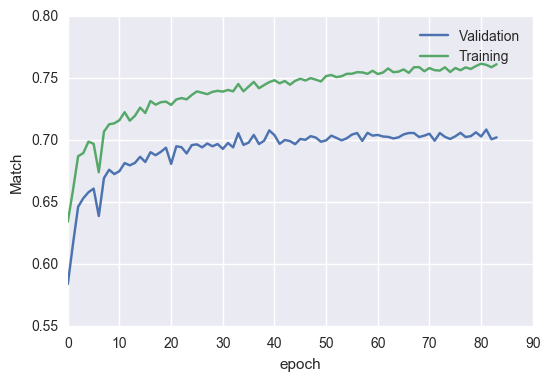

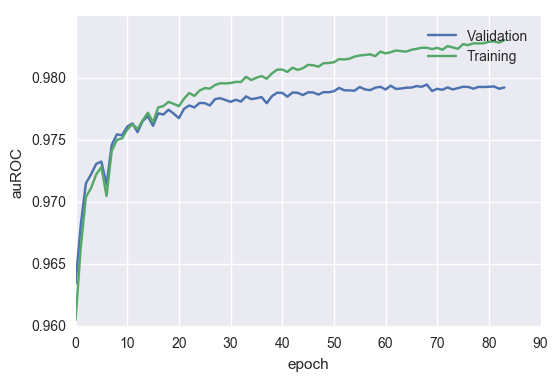

0.708726913859 0.979499245933
0 32 0.001 0.15 0.05 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_15 (Bidirectio (None, 70, 64)            9472      
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
time_distributed_8 (TimeDist (None, 70, 1)             65        
Total params: 34,369
Trainable params: 34,369
Non-trainable params: 0
_________________________________________________________________
None
0 0.5969265473 0.642954377504
1 0.622303679684 0.664190424332
2 0.64866770055 0.68776010268
3 0.652474270407 0.689004706157
4 0.671648103764 0.707245925868
5 0.673903848865 0.705690171522
6 0.679966163823 0.714363502003
7 0.688143239814 0.72054762553
8 0.682503877062 0.717436116837
9 0.68391371775 0.720625413247
10 0.691808825603 0.7249426315

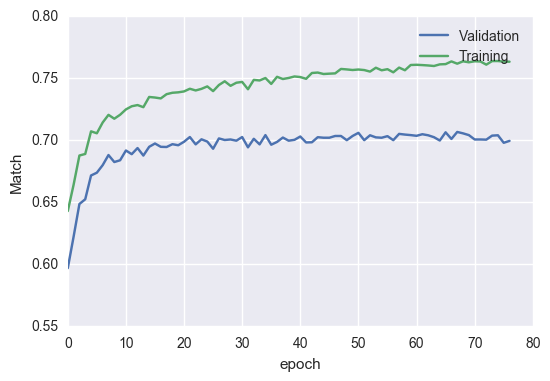

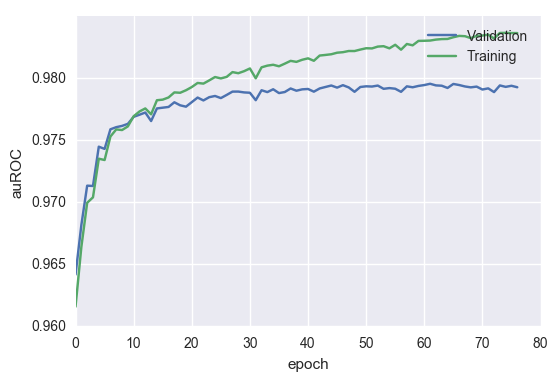

0.706753136896 0.979561054944
0 36 0.001 0.15 0.05 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_17 (Bidirectio (None, 70, 72)            11808     
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 70, 72)            31392     
_________________________________________________________________
time_distributed_9 (TimeDist (None, 70, 1)             73        
Total params: 43,273
Trainable params: 43,273
Non-trainable params: 0
_________________________________________________________________
None
0 0.605667559566 0.64828283614
1 0.639785704215 0.680681420404
2 0.656280840265 0.693788650772
3 0.664457916255 0.703045389133
4 0.665867756943 0.705923534674
5 0.672494008177 0.715452530046
6 0.680953052305 0.719847536074
7 0.687720287608 0.722803469332
8 0.683067813337 0.718097312434
9 0.687861271676 0.724475905255
10 0.690398984915 0.72750

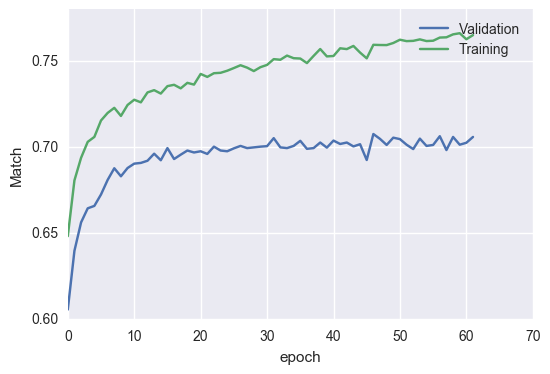

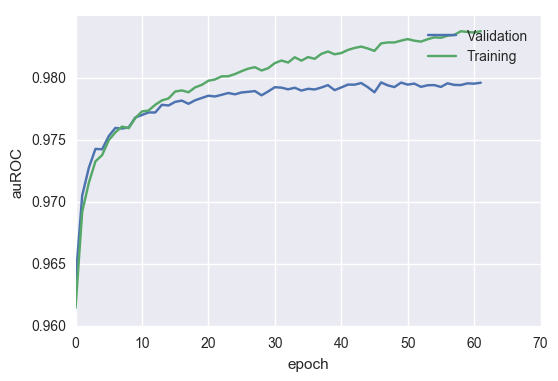

0.707599041308 0.979668705821
0 40 0.001 0.15 0.05 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_19 (Bidirectio (None, 70, 80)            14400     
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 70, 80)            38720     
_________________________________________________________________
time_distributed_10 (TimeDis (None, 70, 1)             81        
Total params: 53,201
Trainable params: 53,201
Non-trainable params: 0
_________________________________________________________________
None
0 0.587339630622 0.63929835479
1 0.642464401523 0.681498191436
2 0.640913576766 0.685193108008
3 0.664316932187 0.699894986582
4 0.674749753278 0.7080626969
5 0.679543211617 0.714324608144
6 0.662625123361 0.70051728832
7 0.683067813337 0.719575279063
8 0.679966163823 0.720430943954
9 0.683490765543 0.721558865855
10 0.696320315804 0.73244914

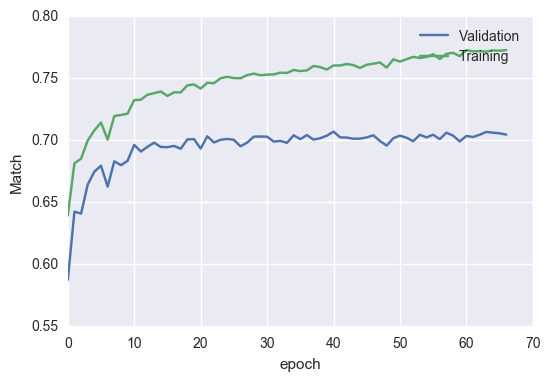

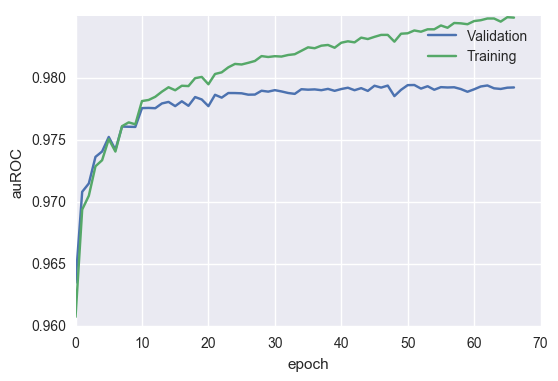

0.707035105033 0.979461995412


In [ ]:
num_layers = [2]
l2s = [0]
hiddens = [28, 32, 36, 40]
lrs = [0.001]
dropouts = [0.15]
r_dropouts = [0.05]

for l2 in l2s:
    for lr in lrs:
        for dropout in dropouts:
            for r_dropout in r_dropouts:
                for num_layer in num_layers:
                    for hidden in hiddens:
                        print l2, hidden, lr, dropout, r_dropout, num_layer
                        model = Sequential()
                        reg = regularizers.l2(0)

                        model.add(Bidirectional(LSTM(hidden, return_sequences = True,
                                                       dropout = dropout, recurrent_dropout = r_dropout,
                                                       kernel_regularizer = reg,
                                                       recurrent_regularizer = reg,
                                                       activity_regularizer = reg,
                                                       bias_regularizer = reg),
                                                 input_shape=(L, 4)))
                        for _ in range(num_layer-1):
                            model.add(Bidirectional(LSTM(hidden, return_sequences = True,
                                                           dropout = dropout, recurrent_dropout = r_dropout,
                                                           kernel_regularizer = reg,
                                                           recurrent_regularizer = reg,
                                                           activity_regularizer = reg,
                                                           bias_regularizer = reg)))

                        model.add(TimeDistributed(Dense(1, kernel_regularizer = regularizers.l2(l2), activation = 'sigmoid')))
                        model.compile(loss='binary_crossentropy',
                                      optimizer=optimizers.Adam(lr=lr,
                                                                beta_1=0.9,
                                                                beta_2=0.999,
                                                                epsilon=1e-08,
                                                                decay=0.0))
                        ModelTrainer(model).train(X_train, X_valid,
                                                  y_train.reshape(-1, 70, 1), y_valid.reshape(-1, 70, 1))

0 32 0.001 0.15 0 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_21 (Bidirectio (None, 70, 64)            9472      
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
time_distributed_11 (TimeDis (None, 70, 1)             65        
Total params: 34,369
Trainable params: 34,369
Non-trainable params: 0
_________________________________________________________________
None
0 0.592838009305 0.642837695928
1 0.646693923587 0.688849130722
2 0.667982517975 0.70312317685
3 0.670379247145 0.7109797363
4 0.674749753278 0.713274473961
5 0.682362892993 0.71938080977
6 0.684900606231 0.72288125705
7 0.691244889328 0.726848430633
8 0.684477654025 0.723931391233
9 0.695897363598 0.729765470032
10 0.693218666291 0.731126755085
11 0.690539968984 0.731437905

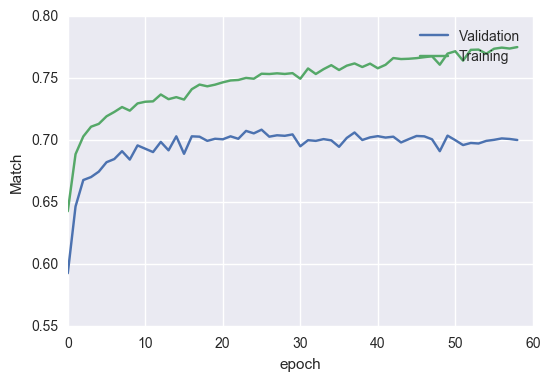

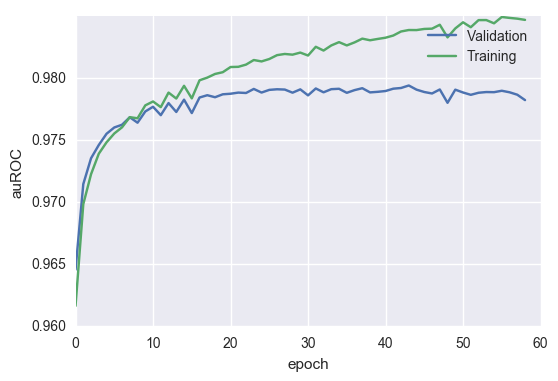

0.70858592979 0.979421967435
0 32 0.001 0.15 0.01 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_23 (Bidirectio (None, 70, 64)            9472      
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
time_distributed_12 (TimeDis (None, 70, 1)             65        
Total params: 34,369
Trainable params: 34,369
Non-trainable params: 0
_________________________________________________________________
None
0 0.579867474975 0.617284430788
1 0.631608628225 0.670996849597
2 0.650500493444 0.688304616701
3 0.663752995911 0.703045389133
4 0.672916960383 0.7109797363
5 0.675595657691 0.717280541403
6 0.672353024108 0.708257166193
7 0.684618638094 0.721597759714
8 0.683208797406 0.723892497375
9 0.686310446919 0.727315156937
10 0.688425207952 0.7320213

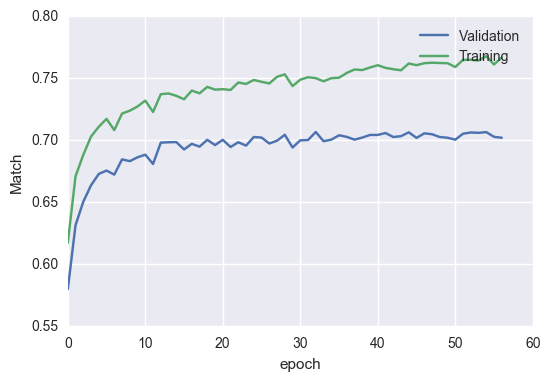

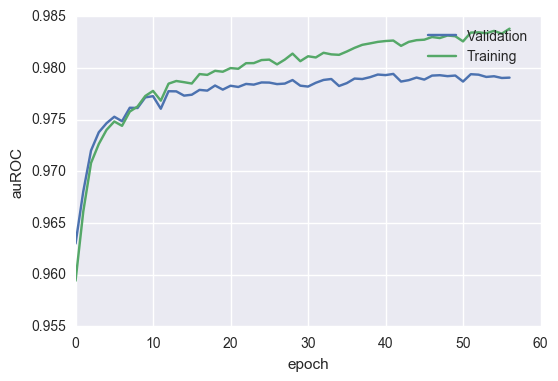

0.706753136896 0.979426414697
0 32 0.001 0.15 0.1 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_25 (Bidirectio (None, 70, 64)            9472      
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
time_distributed_13 (TimeDis (None, 70, 1)             65        
Total params: 34,369
Trainable params: 34,369
Non-trainable params: 0
_________________________________________________________________
None
0 0.571831383054 0.61810120182
1 0.62512336106 0.665901754113
2 0.64627097138 0.690327097351
3 0.648103764275 0.693477499903
4 0.661638234879 0.700595076037
5 0.657690680953 0.698805958539
6 0.663189059636 0.699817198864
7 0.672916960383 0.709929602116
8 0.675454673622 0.71444128972
9 0.68038911603 0.714052351134
10 0.683349781475 0.7221811675

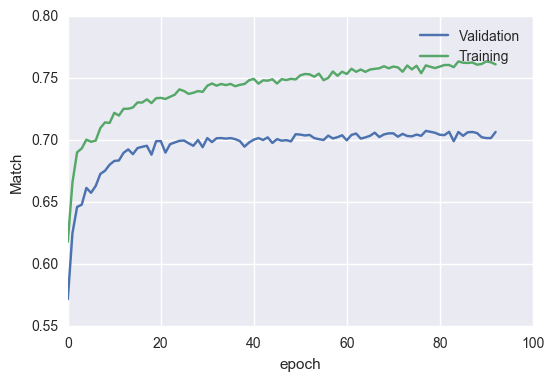

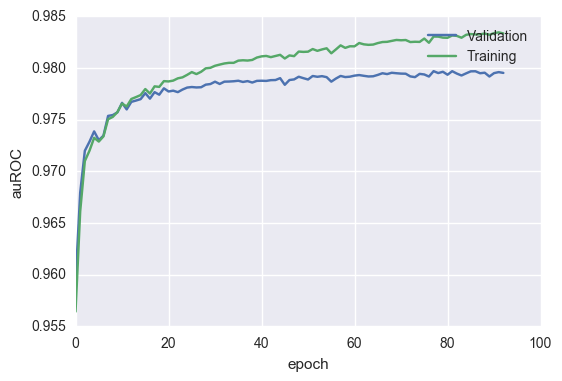

0.707599041308 0.979693556793
0 32 0.001 0.15 0.2 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_27 (Bidirectio (None, 70, 64)            9472      
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
time_distributed_14 (TimeDis (None, 70, 1)             65        
Total params: 34,369
Trainable params: 34,369
Non-trainable params: 0
_________________________________________________________________
None
0 0.587480614691 0.628758119093
1 0.623854504441 0.663762591887
2 0.645989003243 0.684298549259
3 0.648949668687 0.687604527245
4 0.658536585366 0.694060907783
5 0.641195544903 0.684104079966
6 0.661779218948 0.699000427832
7 0.661215282673 0.699000427832
8 0.66981531087 0.707090350434
9 0.65332017482 0.693477499903
10 0.676018609897 0.7136634

In [ ]:
num_layers = [2]
l2s = [0]
hiddens = [32]
lrs = [0.001]
dropouts = [0.15]
r_dropouts = [0, 0.01, 0.1, 0.2]

for l2 in l2s:
    for lr in lrs:
        for dropout in dropouts:
            for r_dropout in r_dropouts:
                for num_layer in num_layers:
                    for hidden in hiddens:
                        print l2, hidden, lr, dropout, r_dropout, num_layer
                        model = Sequential()
                        reg = regularizers.l2(0)

                        model.add(Bidirectional(LSTM(hidden, return_sequences = True,
                                                       dropout = dropout, recurrent_dropout = r_dropout,
                                                       kernel_regularizer = reg,
                                                       recurrent_regularizer = reg,
                                                       activity_regularizer = reg,
                                                       bias_regularizer = reg),
                                                 input_shape=(L, 4)))
                        for _ in range(num_layer-1):
                            model.add(Bidirectional(LSTM(hidden, return_sequences = True,
                                                           dropout = dropout, recurrent_dropout = r_dropout,
                                                           kernel_regularizer = reg,
                                                           recurrent_regularizer = reg,
                                                           activity_regularizer = reg,
                                                           bias_regularizer = reg)))

                        model.add(TimeDistributed(Dense(1, kernel_regularizer = regularizers.l2(l2), activation = 'sigmoid')))
                        model.compile(loss='binary_crossentropy',
                                      optimizer=optimizers.Adam(lr=lr,
                                                                beta_1=0.9,
                                                                beta_2=0.999,
                                                                epsilon=1e-08,
                                                                decay=0.0))
                        ModelTrainer(model).train(X_train, X_valid,
                                                  y_train.reshape(-1, 70, 1), y_valid.reshape(-1, 70, 1))

In [ ]:
num_layers = [1, 2, 3]
l2s = [0, 0.00001, 0.001, 0.01]
hiddens = [28, 32, 26]
lrs = [0.001, 0.0005, 0.0001]
dropouts = [0.05, 0.1, 0.15, 0.2]
r_dropouts = [0.05]

for l2 in l2s:
    for lr in lrs:
        for dropout in dropouts:
            for r_dropout in r_dropouts:
                for num_layer in num_layers:
                    for hidden in hiddens:
                        print l2, hidden, lr, dropout, r_dropout, num_layer
                        model = Sequential()
                        reg = regularizers.l2(l2)

                        model.add(Bidirectional(LSTM(hidden, return_sequences = True,
                                                       dropout = dropout, recurrent_dropout = r_dropout,
                                                       kernel_regularizer = reg,
                                                       recurrent_regularizer = reg),
                                                 input_shape=(L, 4)))
                        for _ in range(num_layer-1):
                            model.add(Bidirectional(LSTM(hidden, return_sequences = True,
                                                           dropout = dropout, recurrent_dropout = r_dropout,
                                                           kernel_regularizer = reg,
                                                           recurrent_regularizer = reg)))

                        model.add(TimeDistributed(Dense(1, activation = 'sigmoid')))
                        model.compile(loss='binary_crossentropy',
                                      optimizer=optimizers.Adam(lr=lr,
                                                                beta_1=0.9,
                                                                beta_2=0.999,
                                                                epsilon=1e-08,
                                                                decay=0.0))
                        ModelTrainer(model).train(X_train, X_valid,
                                                  y_train.reshape(-1, 70, 1), y_valid.reshape(-1, 70, 1))